In [2]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#PATH PROCESS
from pathlib import Path
#IMAGE PROCESS
import cv2
#SCALER & TRANSFORMATION
from sklearn.preprocessing import MinMaxScaler
#OPTIMIZER
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose,LeakyReLU, GaussianNoise, GlobalMaxPooling2D, ReLU, Input, Concatenate
import tensorflow as tf
#Colab
from google.colab import drive
#IGNORING WARNINGS

from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [3]:
# trying: Tensorflow gpu enable
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf. __version__

Num GPUs Available:  1


'2.6.0'

Much more complex and regressive problem related to predicting solar flares
Goal is to create a deep learning model to predict solar flares based on the 800k jpeg dataset


In [4]:
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


# New section

Setting up files and checking tables/csv's

In [5]:
Main_Path = Path('/content/gdrive/MyDrive/Solar/SDOBenchmark_example/training')

In [6]:
Main_Train_CSV = list(Main_Path.glob(r"**/*.csv"))

In [7]:
print(len(Main_Train_CSV))

2


In [8]:
Train_CSV = Main_Train_CSV[0]

In [9]:
print(Train_CSV)

/content/gdrive/MyDrive/Solar/SDOBenchmark_example/training/meta_data.csv


In [10]:
Reading_CSV = pd.read_csv(Train_CSV)

In [11]:
print(Reading_CSV.columns)

Index(['id', 'start', 'end', 'peak_flux'], dtype='object')


In [12]:
print(len(Reading_CSV))

417


In [13]:
print(Reading_CSV.head(-1))

                              id  ...     peak_flux
0    11389_2012_01_01_19_06_00_0  ...  1.882353e-06
1    11390_2012_01_03_02_22_01_1  ...  7.529412e-07
2    11392_2012_01_06_00_09_01_0  ...  3.058824e-06
3    11388_2012_01_07_02_27_01_0  ...  5.764706e-06
4    11394_2012_01_07_12_00_00_0  ...  1.000000e-09
..                           ...  ...           ...
411  12676_2017_09_03_12_00_00_5  ...  1.000000e-09
412  12674_2017_09_05_02_22_00_5  ...  1.000000e-09
413  12683_2017_09_28_01_01_00_3  ...  1.000000e-09
414  12682_2017_10_05_02_49_59_0  ...  1.647059e-07
415  12683_2017_10_06_16_35_59_0  ...  5.411765e-07

[416 rows x 4 columns]


In [14]:
print(Reading_CSV.isnull().sum())

id           0
start        0
end          0
peak_flux    0
dtype: int64


In [15]:
print(Reading_CSV["peak_flux"][0])

1.8823529411764703e-06


In [16]:
print(Reading_CSV["start"][414])

2017-10-04 14:49:59.000000000


In [17]:
print(Reading_CSV["start"][414][0:10])

2017-10-04


Transform date and time to a useable form

In [18]:
print(type(Reading_CSV["start"][414][0:10]))

<class 'str'>


In [19]:
Test_Date_Transform = Reading_CSV["start"][414][0:10].replace("-","")

In [20]:
print(Test_Date_Transform)

20171004


In [21]:
Test_Date_Array = np.array(int(Test_Date_Transform))

In [22]:
print(type(Test_Date_Array))

<class 'numpy.ndarray'>


Begin Data processing

In [23]:
JPG_Path = list(Main_Path.glob(r"**/*.jpg"))

In [24]:
Sorted_JPG_Path = sorted(JPG_Path)

In [25]:
Reading_CSV["New_ID"] = Sorted_JPG_Path[40:457]

In [26]:
print(Reading_CSV.head(-1))

                              id  ...                                             New_ID
0    11389_2012_01_01_19_06_00_0  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
1    11390_2012_01_03_02_22_01_1  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
2    11392_2012_01_06_00_09_01_0  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
3    11388_2012_01_07_02_27_01_0  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
4    11394_2012_01_07_12_00_00_0  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
..                           ...  ...                                                ...
411  12676_2017_09_03_12_00_00_5  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
412  12674_2017_09_05_02_22_00_5  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
413  12683_2017_09_28_01_01_00_3  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
414  12682_2017_10_05_02_49_59_0  ...  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...
415  12683_2017_10_06

In [27]:
print(Reading_CSV["New_ID"][0])
print("---"*10)
print(Reading_CSV["id"][0])

/content/gdrive/MyDrive/Solar/SDOBenchmark_example/training/11388/2012_01_07_02_27_01_0/2012-01-07T005701__131.jpg
------------------------------
11389_2012_01_01_19_06_00_0


Building New data

In [28]:
New_Start = []
New_End = []
New_Path = []

for x_start, x_end, x_path in zip(Reading_CSV.start.values,Reading_CSV.end.values,Reading_CSV.New_ID.values):

    x_start = x_start[0:10]
    x_start = x_start.replace("-","")
    x_start = np.array(x_start,dtype="float32")

    x_end = x_end[0:10]
    x_end = x_end.replace("-","")
    x_end = np.array(x_end,dtype="float32")

    New_Start.append(x_start)
    New_End.append(x_end)
    New_Path.append(x_path)

In [29]:
print("LEN START: ", len(New_Start))
print("LEN END: ", len(New_End))
print("LEN PATH: ", len(New_Path))

LEN START:  417
LEN END:  417
LEN PATH:  417


In [30]:
print(New_Start[0])
print("--"*10)
print(New_End[0])
print("--"*10)
print(New_Path[0])

20120100.0
--------------------
20120100.0
--------------------
/content/gdrive/MyDrive/Solar/SDOBenchmark_example/training/11388/2012_01_07_02_27_01_0/2012-01-07T005701__131.jpg


Dataframe

In [31]:
Start_Series = pd.Series(New_Start,name="START").astype(np.float32)
End_Series = pd.Series(New_End,name="END").astype(np.float32)
Path_Series = pd.Series(New_Path,name="PATH").astype(str)

In [32]:
Main_Data = pd.concat([Path_Series,Start_Series,End_Series],axis=1)

In [33]:
print(Main_Data.head(-1))

                                                  PATH       START         END
0    /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20120100.0  20120100.0
1    /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20120104.0  20120104.0
2    /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20120104.0  20120106.0
3    /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20120106.0  20120108.0
4    /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20120108.0  20120108.0
..                                                 ...         ...         ...
411  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20170904.0  20170906.0
412  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20170908.0  20170908.0
413  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20170930.0  20171000.0
414  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20171004.0  20171004.0
415  /content/gdrive/MyDrive/Solar/SDOBenchmark_exa...  20171006.0  20171006.0

[416 rows x 3 columns]


Testing various image display configurations
Vision
Single

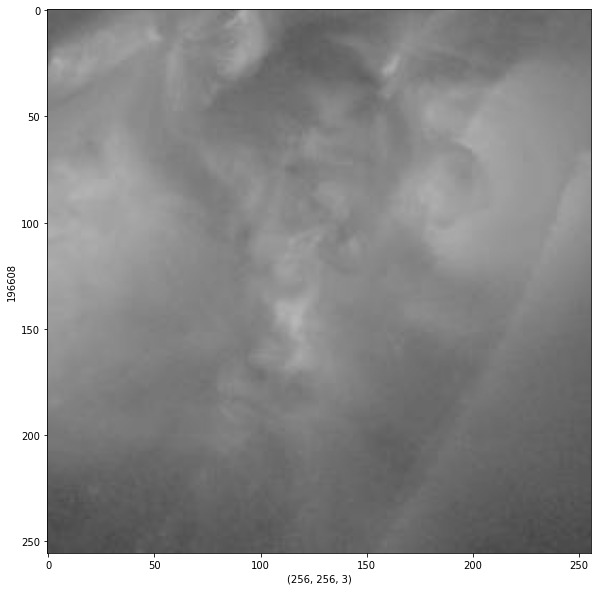

In [34]:
Example_IMG = cv2.cvtColor(cv2.imread(Main_Data["PATH"][33]), cv2.COLOR_BGR2RGB)

figure = plt.figure(figsize=(10,10))

plt.xlabel(Example_IMG.shape)
plt.ylabel(Example_IMG.size)
plt.imshow(Example_IMG)

#plt.show()

Multi

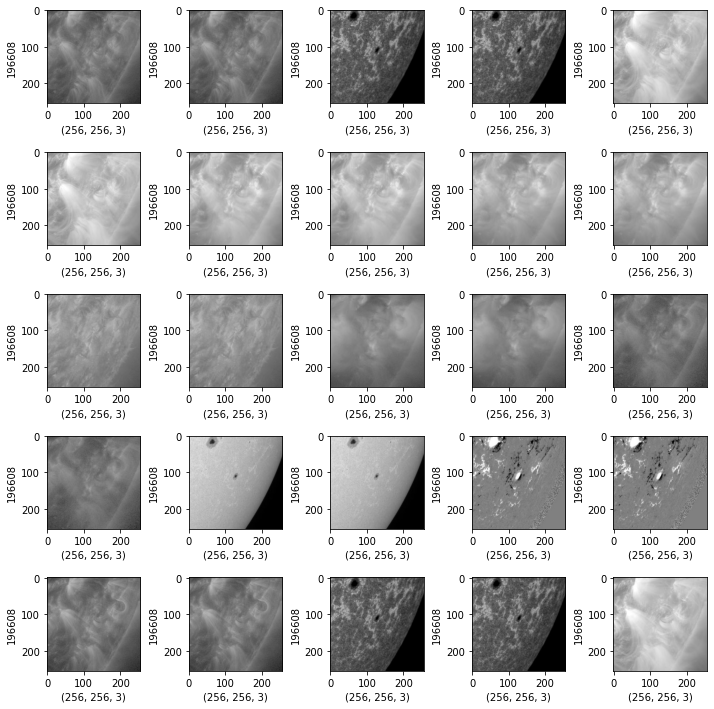

In [35]:
figure,axis = plt.subplots(5,5,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):

    Reading_IMG = cv2.cvtColor(cv2.imread(Main_Data["PATH"][indexing]),cv2.COLOR_BGR2RGB)

    operations.set_xlabel(Reading_IMG.shape)
    operations.set_ylabel(Reading_IMG.size)
    operations.imshow(Reading_IMG)

plt.tight_layout()
#plt.show()

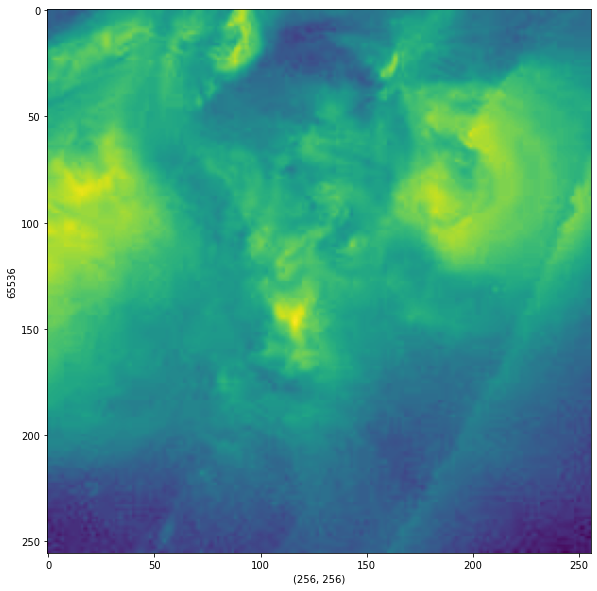

In [36]:
#2D
Example_IMG = cv2.cvtColor(cv2.imread(Main_Data["PATH"][13]), cv2.COLOR_BGR2RGB)

figure = plt.figure(figsize=(10,10))

plt.xlabel(Example_IMG[:,:,0].shape)
plt.ylabel(Example_IMG[:,:,0].size)
plt.imshow(Example_IMG[:,:,0])
#plt.show()

Treshold image

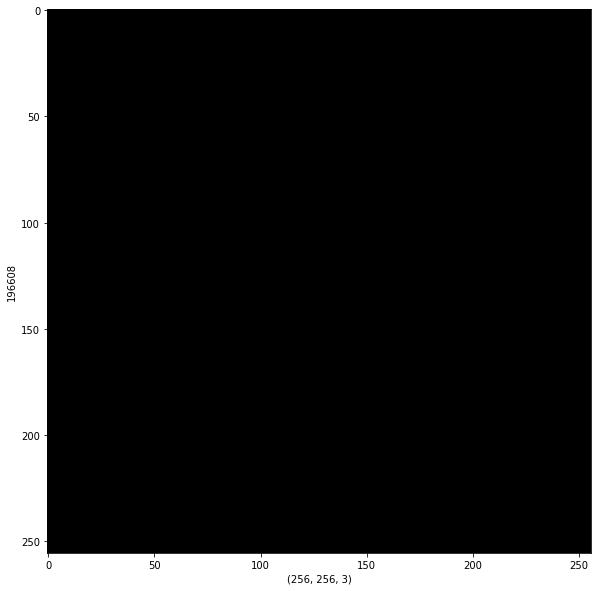

In [37]:
Example_IMG = cv2.cvtColor(cv2.imread(Main_Data["PATH"][13]),cv2.COLOR_BGR2RGB)
_,Threshold_IMG = cv2.threshold(Example_IMG,200,255,cv2.THRESH_BINARY)

figure = plt.figure(figsize=(10,10))

plt.xlabel(Threshold_IMG.shape)
plt.ylabel(Threshold_IMG.size)
plt.imshow(Threshold_IMG)
#plt.show()

Varius other image types can be used such as Layer concat, Countours, Canny-treshold concat etc.

Data transformation

In [38]:
X_Start = []
X_End = []
X_Image = []

for img,start_i, end_i in zip(Main_Data.PATH.values, Main_Data.START.values, Main_Data.END.values):
    Picking_IMG = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    Picking_IMG = cv2.resize(Picking_IMG, (180,180))
    Picking_IMG = Picking_IMG / 255.

    X_Image.append(Picking_IMG)
    X_Start.append(start_i)
    X_End.append(end_i)

In [39]:
print(np.shape(np.array(X_Image)))
print(np.shape(np.array(X_Start)))
print(np.shape(np.array(X_End)))

(417, 180, 180, 3)
(417,)
(417,)


In [40]:
Train_JPG = np.array(X_Image,dtype = "float32")
Train_START = np.array(X_Start,dtype="float32")
Train_END = np.array(X_End,dtype="float32")

In [41]:
print(Train_JPG.shape)
print(Train_START.shape)
print(Train_END.shape)

(417, 180, 180, 3)
(417,)
(417,)


In [42]:
Scalar_Function = MinMaxScaler()

Train_START_R = Scalar_Function.fit_transform(Train_START.reshape(-1,1))
Train_END_R = Scalar_Function.fit_transform(Train_END.reshape(-1,1))

Auto-encoder

In [43]:
X_Mask = []
X_New_IMG = []

for img_i in Main_Data.PATH.values:
    Picking_IMG = cv2.cvtColor(cv2.imread(img_i),cv2.COLOR_BGR2RGB)
    _,Threshold_IMG = cv2.threshold(Picking_IMG,200,255,cv2.THRESH_BINARY)
    Canny_IMG = cv2.Canny(Threshold_IMG, 10,100)

    Copy_Main = Picking_IMG.copy()
    Copy_Main[Canny_IMG == 255] = [255,0,0]

    Copy_Main = cv2.resize(Copy_Main, (180,180))
    Copy_Main = Copy_Main / 255.

    Picking_IMG = cv2.resize(Picking_IMG, (180,180))
    Picking_IMG = Picking_IMG / 255.

    X_Mask.append(Copy_Main)
    X_New_IMG.append(Picking_IMG)

In [44]:
X_Mask = np.array(X_Mask,dtype="float32")
X_New_IMG = np.array(X_New_IMG,dtype="float32")

In [45]:
print(X_New_IMG.shape)
print(X_Mask.shape)

(417, 180, 180, 3)
(417, 180, 180, 3)


(-0.5, 179.5, 179.5, -0.5)

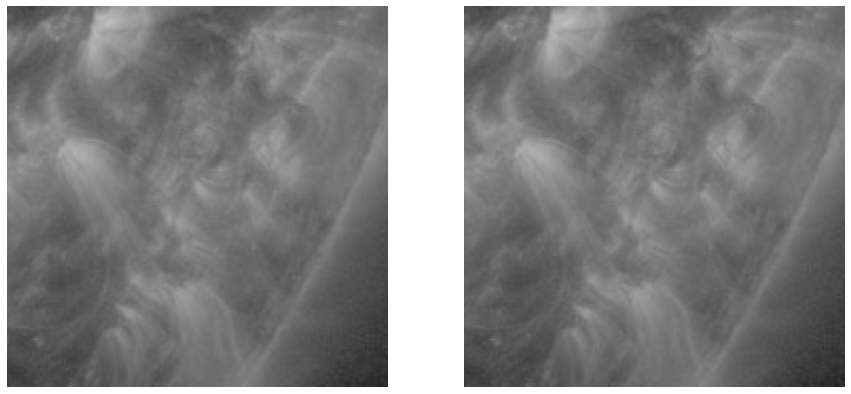

In [46]:
figure,axis = plt.subplots(1,2, figsize=(15,15))

axis[0].imshow(X_New_IMG[0])
axis[0].axis("off")
axis[1].imshow(X_Mask[0])
axis[1].axis("off")

(-0.5, 179.5, 179.5, -0.5)

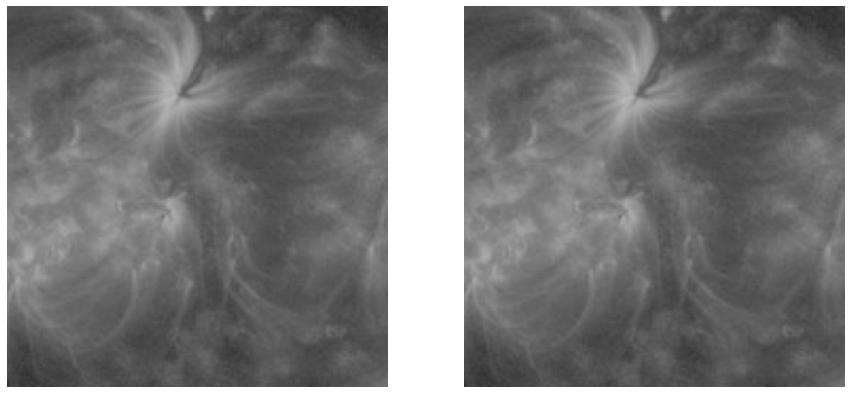

In [47]:
figure,axis = plt.subplots(1,2, figsize=(15,15))

axis[0].imshow(X_New_IMG[100])
axis[0].axis("off")
axis[1].imshow(X_Mask[100])
axis[1].axis("off")

Encoder model

Parameters / Callbacks

In [48]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy", save_best_only=True, save_weights_only=True, filepath="./modelcheck")
Reduce_Model = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=0.5)

In [49]:
compile_loss = "binary_crossentropy"
compile_optimizers = Adam(lr=0.0000001)
output_class = 1

Structure, building model layers. 4 convolution layers into 4 transposed convolutions. he_normal weights matrix and padding for dimension consistency

In [50]:
E_AE = Sequential()

E_AE.add(Conv2D(32,(5,5), kernel_initializer= 'he_normal', use_bias=True, padding="valid"))
E_AE.add(BatchNormalization())
E_AE.add(ReLU())

E_AE.add(Conv2D(64,(5,5), kernel_initializer= 'he_normal',use_bias= True, padding="valid"))
E_AE.add(BatchNormalization())
E_AE.add(ReLU())

E_AE.add(Conv2D(128,(5,5), kernel_initializer= 'he_normal', use_bias= True, padding="valid"))
E_AE.add(BatchNormalization())
E_AE.add(ReLU())

E_AE.add(Conv2D(256,(5,5), kernel_initializer= 'he_normal', use_bias=True, padding="valid"))
E_AE.add(BatchNormalization())
E_AE.add(ReLU())

D_AE = Sequential()

D_AE.add(Conv2DTranspose(128,(5,5), padding="valid"))
D_AE.add(ReLU())

D_AE.add(Conv2DTranspose(64,(5,5), padding="valid"))
D_AE.add(ReLU())

D_AE.add(Conv2DTranspose(32,(5,5), padding="valid"))
D_AE.add(ReLU())

D_AE.add(Conv2DTranspose(output_class,(5,5)))
D_AE.add(ReLU())

In [51]:
Auto_Encoder = Sequential([E_AE, D_AE])
Auto_Encoder.compile(loss=compile_loss, optimizer=compile_optimizers, metrics=["mse"])

In [52]:
Model_Autoencoder = Auto_Encoder.fit(X_New_IMG, X_Mask, epochs=55, callbacks=[Checkpoint_Model])

Epoch 1/55
14/14 [==============================] - 86s 3s/step - loss: 3.5240 - mse: 0.1950
Epoch 2/55
14/14 [==============================] - 40s 3s/step - loss: 3.4348 - mse: 0.1916
Epoch 3/55
14/14 [==============================] - 39s 3s/step - loss: 3.3364 - mse: 0.1878
Epoch 4/55
14/14 [==============================] - 39s 3s/step - loss: 3.2356 - mse: 0.1834
Epoch 5/55
14/14 [==============================] - 40s 3s/step - loss: 3.1230 - mse: 0.1796
Epoch 6/55
14/14 [==============================] - 39s 3s/step - loss: 3.0437 - mse: 0.1766
Epoch 7/55
14/14 [==============================] - 39s 3s/step - loss: 2.9517 - mse: 0.1734
Epoch 8/55
14/14 [==============================] - 39s 3s/step - loss: 2.8766 - mse: 0.1698
Epoch 9/55
14/14 [==============================] - 39s 3s/step - loss: 2.8052 - mse: 0.1668
Epoch 10/55
14/14 [==============================] - 40s 3s/step - loss: 2.7435 - mse: 0.1636
Epoch 11/55
14/14 [==============================] - 40s 3s/step - lo

TypeError: ignored

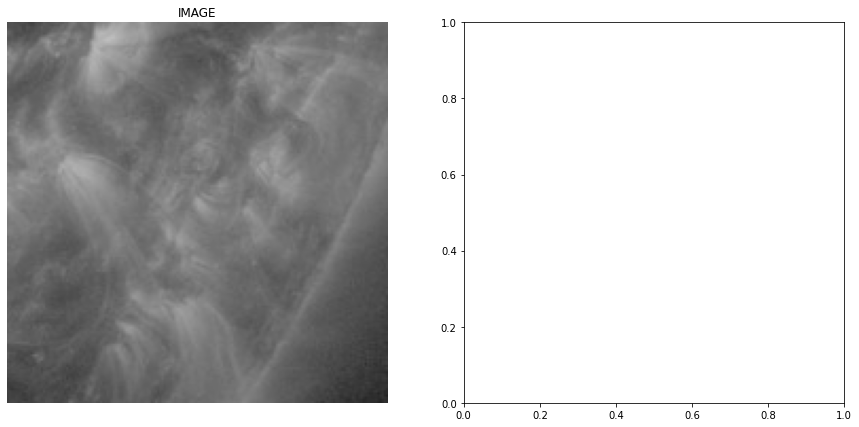

In [54]:
Prediction_MASK_Seen = Auto_Encoder.predict(X_New_IMG[:20])
figure,axis = plt.subplots(1,2,figsize=(15,15))
pre_img_number = 1

Original_Img = X_New_IMG[pre_img_number]
Predict_Mask = Prediction_MASK_Seen[pre_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[0].axis("off")
axis[1].imshow(Predict_Mask)
axis[1].set_xlabel(Predict_Mask.shape)
axis[1].set_ylabel(Predict_Mask.size)
axis[1].set_title("PREDICTION")
axis[1].axis("off")

In [55]:
#predict test sets
Reading_IMG = cv2.cvtColor(cv2.imread("/content/gdrive/MyDrive/Solar/SDOBenchmark_example/test/11476/2012_05_14_16_18_57_0/2012-05-14T041857__335.jpg"),cv2.COLOR_BGR2RGB)
Reading_IMG = cv2.resize(Reading_IMG,(180,180))

In [56]:
Reading_IMG_Shape = Reading_IMG.reshape(1,Reading_IMG.shape[0],Reading_IMG.shape[1],Reading_IMG.shape[2])

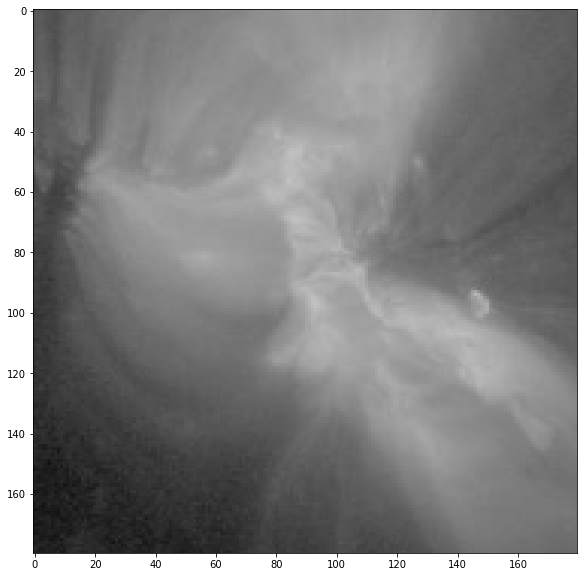

In [57]:
figure = plt.figure(figsize=(10,10))

plt.imshow(Reading_IMG)

In [ ]:
#testing random predicts

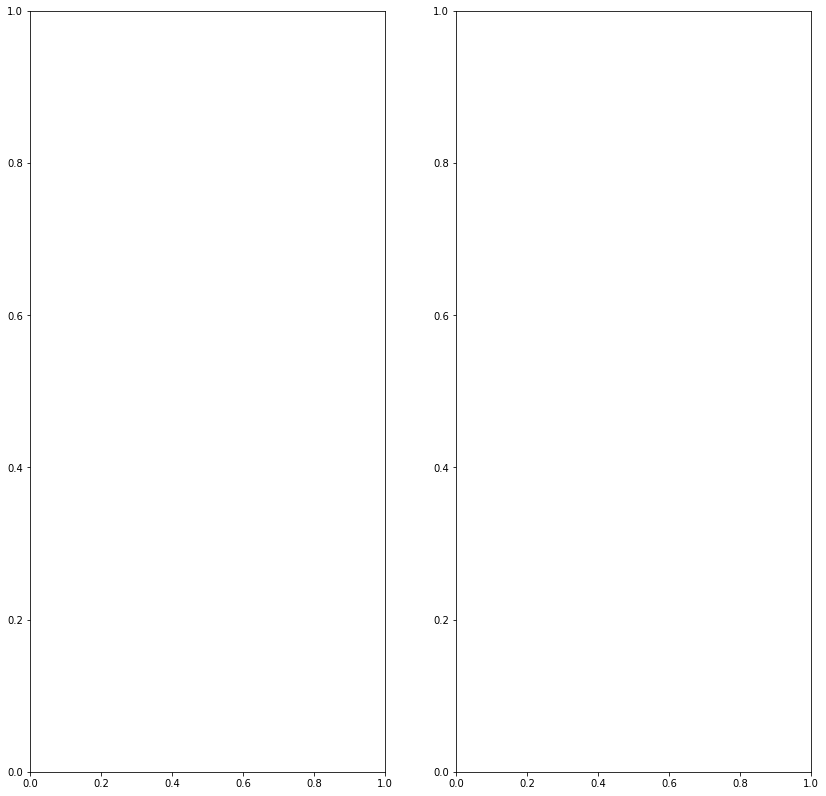

In [58]:
MASK_Seen = Auto_Encoder.predict(Reading_IMG_Shape)
figure,axis = plt.subplots(1,2,figsize=(14,14))

In [59]:
axis[0].imshow(Reading_IMG)
axis[0].set_xlabel(Reading_IMG.shape)
axis[0].set_ylabel(Reading_IMG.size)
axis[0].set_title("IMAGE")
axis[0].axis("off")
axis[1].imshow(MASK_Seen[0])
axis[1].set_xlabel(MASK_Seen[0].shape)
axis[1].set_ylabel(MASK_Seen[0].size)
axis[1].set_title("PREDICTION")
axis[1].axis("off")

TypeError: ignored

In [60]:
encoder = Sequential()
encoder.add(Flatten(input_shape=[180,180,3]))
encoder.add(Dense(300,activation="relu"))
encoder.add(Dense(200,activation="relu"))
encoder.add(Dense(100,activation="relu"))
encoder.add(Dense(50,activation="relu"))
encoder.add(Dense(25,activation="relu"))

decoder = Sequential()
decoder.add(Dense(50,input_shape=[25],activation="relu"))
decoder.add(Dense(100,activation="relu"))
decoder.add(Dense(200,activation="relu"))
decoder.add(Dense(300,activation="relu"))
decoder.add(Dense(180*180*3,activation="sigmoid"))
decoder.add(Reshape([180,180,3]))

In [61]:
AutoEncoder_II = Sequential([encoder,decoder])

In [62]:
AutoEncoder_II.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["mse"])

In [63]:
AutoEncoder_II.fit(X_New_IMG,X_New_IMG,epochs=40)

Epoch 1/40
14/14 [==============================] - 2s 75ms/step - loss: 0.7282 - mse: 0.0469
Epoch 2/40
14/14 [==============================] - 1s 69ms/step - loss: 0.6879 - mse: 0.0349
Epoch 3/40
14/14 [==============================] - 1s 70ms/step - loss: 0.6884 - mse: 0.0351
Epoch 4/40
14/14 [==============================] - 1s 67ms/step - loss: 0.6877 - mse: 0.0348
Epoch 5/40
14/14 [==============================] - 1s 69ms/step - loss: 0.6861 - mse: 0.0340
Epoch 6/40
14/14 [==============================] - 1s 68ms/step - loss: 0.6831 - mse: 0.0326
Epoch 7/40
14/14 [==============================] - 1s 69ms/step - loss: 0.6948 - mse: 0.0362
Epoch 8/40
14/14 [==============================] - 1s 69ms/step - loss: 0.6878 - mse: 0.0343
Epoch 9/40
14/14 [==============================] - 1s 70ms/step - loss: 0.6720 - mse: 0.0279
Epoch 10/40
14/14 [==============================] - 1s 69ms/step - loss: 0.6714 - mse: 0.0279
Epoch 11/40
14/14 [==============================] - 1s 69m

In [64]:
PRE_Img = AutoEncoder_II.predict(X_New_IMG[:10])

(-0.5, 179.5, 179.5, -0.5)

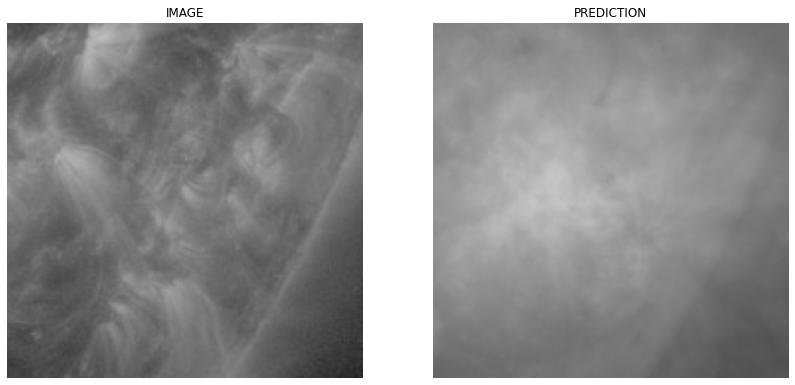

In [67]:
figure,axis = plt.subplots(1,2,figsize=(14,14))
pre_img_number = 1

Original_Img = X_New_IMG[pre_img_number]
Predict_Reduce = PRE_Img[pre_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[0].axis("off")
axis[1].imshow(Predict_Reduce)
axis[1].set_xlabel(Predict_Reduce.shape)
axis[1].set_ylabel(Predict_Reduce.size)
axis[1].set_title("PREDICTION")
axis[1].axis("off")

(-0.5, 179.5, 179.5, -0.5)

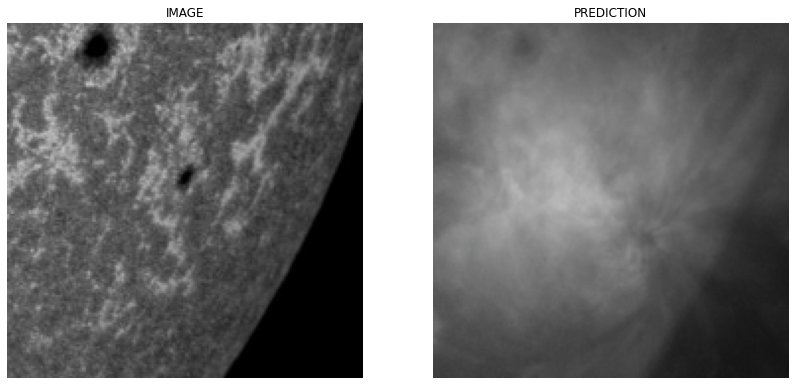

In [68]:
figure,axis = plt.subplots(1,2,figsize=(14,14))
pre_img_number = 2

Original_Img = X_New_IMG[pre_img_number]
Predict_Reduce = PRE_Img[pre_img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[0].axis("off")
axis[1].imshow(Predict_Reduce)
axis[1].set_xlabel(Predict_Reduce.shape)
axis[1].set_ylabel(Predict_Reduce.size)
axis[1].set_title("PREDICTION")
axis[1].axis("off")